# Obligatory assignment - **MEK4250** - *Trym Erik Nielsen*

## Required imports

In [10]:
from dolfin import *
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from IPython.display import display
%matplotlib inline

## Boundary class definitions

In [11]:
class Right(SubDomain):
    def inside(self, x, on_boundary, eps=1.e-14):
        return x[0] > 1 - eps


class Left(SubDomain):
    def inside(self, x, on_boundary, eps=1.e-14):
        return x[0] < eps

## Problem specific solver functions

In [18]:
def solver_prob_1(N=8, deg=1, k=1):
    mesh = UnitSquareMesh(N, N)
    V = FunctionSpace(mesh, 'P', deg)

    #numerical and analytical expressions
    u_e = Expression('sin(pi*k*x[0])*cos(pi*k*x[1])', degree=deg, k=k)
    u_num = Function(V)

    #Boundary conditions
    bcs = [DirichletBC(V, Constant(0.0), Left()),
           DirichletBC(V, Constant(0.0), Right())]

    u = TrialFunction(V)
    v = TestFunction(V)

    f = Expression('2*pi*pi*k*k*sin(pi*k*x[0])*cos(pi*k*x[1])',degree=deg, k=k)
    a = dot(grad(u), grad(v)) * dx
    L = f * v * dx

    u = Function(V)
    solve(a == L, u, bcs)
    
    return mesh, u, V


def solver_prob_2(N=8, mu=1, deg=1, galerkin=False):
    
    mesh = UnitSquareMesh(N, N)
    V = FunctionSpace(mesh, 'P', deg)
    u_num = Function(V)
    
    bcs = [
        DirichletBC(V, Constant(0.0), Left()),
        DirichletBC(V, Constant(1.0), Right()),
    ]
    
    u = TrialFunction(V)
    v = TestFunction(V)
    
    if galerkin:
        beta = 0.5 * mesh.hmin()
        v  = v + beta * v.dx(0)
    
    f = Constant(0.0)
    g = Constant(0.0)    
    
    a = mu * inner(grad(u), grad(v)) * dx + u.dx(0) * v * dx
    L = f * v * dx + g * v * ds
    
    solve(a==L, u_num, bcs)
    
    return u_num, V, mesh

## Problem functions

We can now define problem functions that call our problem specific solvers. We use pandas dataframes to display the errornorms for different frequencies and mesh refinements using the FEniCS built in errornorm function. Since errornorm does not support the $L_\infty$ errornorm, we project our expression for the exact solution onto our subspace and take the maximum of the absolute value of the difference with the numerical solution. 

We also define the error fitting function that creates a linear best-fit between our error norms $L_2$ and $H_1$

In [27]:
def error_fit(L_2, H_1):
    N = L_2.index.values
    param = L_2.columns.values
    best_fit_coeffs = pd.DataFrame(index=param, columns=['alpha', 'C_alpha', 'beta', 'C_beta'])
    h_log = [np.log(1.0 / n) for n in N]
    L_2_log = L_2.applymap(np.log)
    H_1_log = H_1.applymap(np.log)
    
    plt.plot(h_log, L_2_log, 'r', h_log, H_1_log, 'b')
    plt.title('LogLog plot of error norm VS cell size')
    plt.xlabel('log(h)')
    plt.ylabel('log(L_2) / Log(H_1)')
    plt.show()
    
    for p in param:
        L_2_fit = np.polyfit(h_log, L_2_log[p], deg=1)
        H_1_fit = np.polyfit(h_log, H_1_log[p], deg=1)
        
        L_2_fit[1] = np.exp(L_2_fit[1])
        H_1_fit[1] = np.exp(H_1_fit[1])
    
        best_fit_coeffs.loc[p] = list(L_2_fit) + list(H_1_fit)


    return best_fit_coeffs   

def prob_1(deg=1):
    
    N = [8, 16, 32, 64]
    freqs = [1, 2, 4,8]
    L_2_error = pd.DataFrame(index=N, columns=freqs)
    L_inf_error = pd.DataFrame(index=N, columns=freqs)
    H_1_error = pd.DataFrame(index=N, columns=freqs)
    
    
    for n in N:
        for freq in freqs:
                mesh,u_num,V = solver_prob_1(N=n, deg=deg, k=freq)
                u_ex = Expression('sin(k*pi*x[0])*cos(k*pi*x[1])', k=freq, degree=deg) 
                
                L_2 = errornorm(u_ex, u_num, 'l2', degree_rise=1)
                H_1 = errornorm(u_ex, u_num, 'H1', degree_rise=1)
                
                u_ex_values = interpolate(u_ex, V)
                u_ex_vector = u_ex_values.vector()
                u_num_vector = u_num.vector()
                L_inf = max(np.abs(u_ex_vector - u_num_vector))

                L_2_error.at[n, freq] = L_2
                L_inf_error.at[n, freq] = L_inf
                H_1_error.at[n, freq] = H_1
    
    
    print('----- problem 1 - part b -------' + '\n')
    print('L2 error norm' + '\n')
    display(L_2_error)
    print('L_inf error norm' + '\n')
    display(L_inf_error)
    print('H1 error norm' + '\n')
    display(H_1_error)
    print('\n\n\n')
    print('----- problem 1 - part c -------' + '\n')
    print('Best fit parameters')
    display(error_fit(L_2_error, H_1_error))
    
    #plot highest accuracy mesh and u  
    if deg > 1:
        p = plot(u_num)
        p.set_cmap('plasma')
        p.set_clim(0.0, 1.0)
        plt.title('u solution')
        plt.colorbar(p)
        plt.show()

        
def prob_2(deg=1, galerkin=False):
    mu_values = [0.1, 0.3, 1.0]
    N = [8, 16, 32, 64]

    L_2_error = pd.DataFrame(index=N, columns=mu_values)
    L_inf_error = pd.DataFrame(index=N, columns=mu_values)
    H_1_error = pd.DataFrame(index=N, columns=mu_values)
    
    for mu in mu_values:
        for n in N:
            u_num, V, omega = solver_prob_2(N=n, mu=mu, deg=deg, galerkin=galerkin)
            u_ex = Expression('(exp(1 / mu * x[0]) - 1) / (exp(1 / mu) - 1)', mu=mu, degree=deg)

            L_2 = errornorm(u_ex, u_num, 'L2', degree_rise=3)
            H_1 = errornorm(u_ex, u_num, 'H1', degree_rise=3)
            u_ex_values = interpolate(u_ex, V)
            u_ex_vector = u_ex_values.vector()
            u_num_vector = u_num.vector()
            L_inf = max(np.abs(u_ex_vector - u_num_vector))
            
            L_2_error.at[n, mu] = L_2
            L_inf_error.at[n, mu] = L_inf
            H_1_error.at[n, mu] = H_1
            
    print('----- problem 2 - part b -------' + '\n')
    print('L2 error norm' + '\n')
    display(L_2_error)
    print('L_inf error norm' + '\n')
    display(L_inf_error)
    print('H1 error norm' + '\n')
    display(H_1_error)
    print('\n\n\n')
    print('----- problem 2 - part c -------' + '\n')
    print('Best fit parameters')
    display(error_fit(L_2_error, H_1_error))
            
    if deg >= 1:
        p = plot(u_num)
        p.set_cmap('plasma')
        p.set_clim(0.0, 1.0)
        plt.title('u solution')
        plt.colorbar(p)
        plt.show()

### $H^P$ norm of $u$

The $H^P$ norm of the function $u$ can be expressed as
$$\vert \vert \, u \, \vert \vert_P = \left( \sum^{}_{|\alpha|\leq p} \int_\Omega
    \big(\frac{\partial^{|\alpha|} u}{\partial {x}^\alpha}\big)^2 \, dx
\right)^{1/2}$$ 

with $\alpha = (i,j)$ in the two dimensional Cartesian space. Using our assumed $u$, and the fact that $f = - \Delta u  = 2\pi^2 k^2 u$, we find

$$\vert \vert \, u \, \vert \vert_P = \frac{1}{2} \Big(\sum^{}_{|\alpha| \leq p} (k\pi)^{2|\alpha|}\Big)^{1/2}$$

Since $\int_0^1 \sin(\pi k x) = \int_0^1 \cos(\pi k y) = \frac{1}{2}$

### Problem 1, Lagrange elements order 1

----- problem 1 - part b -------

L2 error norm



,1,2,4,8
8,0.0327134,0.126466,0.303989,0.421637
16,0.00845879,0.0360234,0.124987,0.298277
32,0.00213295,0.009314,0.0358724,0.124795
64,0.000534392,0.00234834,0.00929057,0.0359663


L_inf error norm



,1,2,4,8
8,0.0374752,0.173276,0.482934,9.79717e-16
16,0.00978353,0.0473498,0.171247,0.482693
32,0.0024616,0.0120996,0.0467505,0.171114
64,0.000616387,0.00304138,0.0119439,0.0467122


H1 error norm



,1,2,4,8
8,0.436629,1.73058,6.17599,18.48
16,0.218173,0.872448,3.44912,12.2594
32,0.109056,0.436258,1.74356,6.88985
64,0.0545238,0.218102,0.872358,3.48637






----- problem 1 - part c -------

Best fit parameters


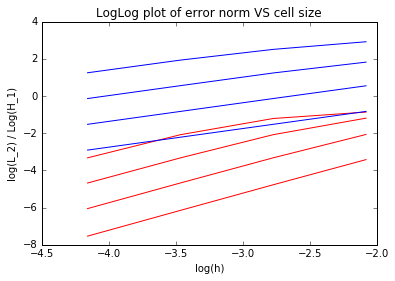

,alpha,C_alpha,beta,C_beta
1,1.97951,2.02411,1.00047,3.49595
2,1.92043,7.09742,0.996444,13.7769
4,1.68972,11.6033,0.945522,45.5484
8,1.19109,6.3301,0.804985,105.779


In [28]:
prob_1()

### Problem 1, Lagrange elements order 2

Calling FFC just-in-time (JIT) compiler, this may take some time.
----- problem 1 - part b -------

L2 error norm



,1,2,4,8
8,0.000568795,0.00495767,0.0450458,0.305222
16,6.93305e-05,0.000570275,0.00496087,0.0452697
32,8.61128e-06,6.94028e-05,0.000570722,0.00498072
64,1.07511e-06,8.61702e-06,6.9447e-05,0.000571757


L_inf error norm



,1,2,4,8
8,0.000735545,0.00665548,0.0639175,0.494596
16,8.80406e-05,0.000741005,0.00664197,0.0638915
32,1.08331e-05,9.01769e-05,0.000740577,0.00664111
64,1.3658e-06,1.15708e-05,8.93791e-05,0.00074055


H1 error norm



,1,2,4,8
8,0.0331409,0.256453,1.83608,11.3549
16,0.00838664,0.066496,0.514056,3.67091
32,0.00210537,0.0168044,0.133221,1.02936
64,0.000527159,0.00421483,0.0336408,0.266677






----- problem 1 - part c -------

Best fit parameters


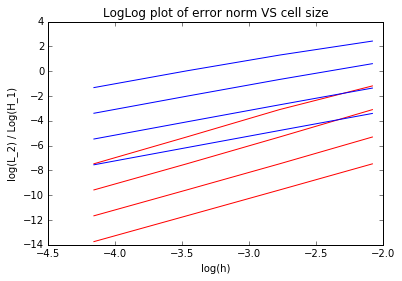

,alpha,C_alpha,beta,C_beta
1,3.0151,0.298514,1.99167,2.0907
2,3.05434,2.78314,1.97657,15.7771
4,3.11435,28.5518,1.92589,103.625
8,3.03648,182.835,1.80706,515.869


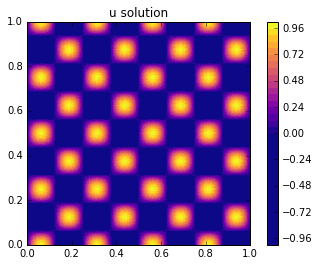

In [23]:
prob_1(2)

### Problem 2, without SUPG stablization, Lagrange elements order 2

----- problem 2 - part b -------

L2 error norm



,0.1,0.3,1.0
8,0.0237473,0.00496957,0.00140249
16,0.00617686,0.00125284,0.000350758
32,0.00156133,0.000313907,8.76984e-05
64,0.000391471,7.85213e-05,2.19252e-05


L_inf error norm



,0.1,0.3,1.0
8,0.102246,0.00956397,0.000594796
16,0.0236434,0.00238083,0.000150234
32,0.00600694,0.000599617,3.76462e-05
64,0.00150666,0.000149844,9.41695e-06


H1 error norm



,0.1,0.3,1.0
8,0.769237,0.159755,0.0375224
16,0.398389,0.0803121,0.0187656
32,0.201077,0.0402122,0.00938338
64,0.100781,0.0201132,0.00469176






----- problem 2 - part c -------

Best fit parameters


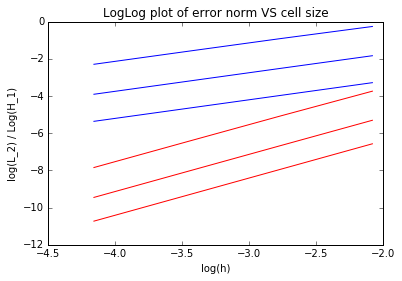

,alpha,C_alpha,beta,C_beta
0.1,1.97522,1.45832,0.978303,5.93637
0.3,1.99485,0.31535,0.996692,1.27108
1.0,1.99976,0.0897242,0.999856,0.300108


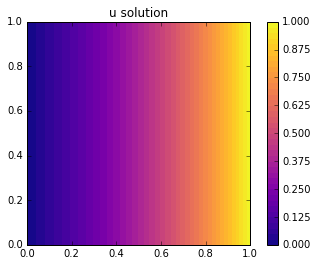

In [29]:
prob_2(1)

### Problem 2, with SUPG stabalization, Lagrange elements order 1 

----- problem 2 - part b -------

L2 error norm



,0.1,0.3,1.0
8,0.116845,0.0508915,0.00817331
16,0.0633218,0.0271282,0.00396968
32,0.03313,0.0140583,0.00195639
64,0.0169821,0.00716368,0.000971209


L_inf error norm



,0.1,0.3,1.0
8,0.230657,0.073797,0.010013
16,0.134348,0.0403927,0.00518187
32,0.0727037,0.0212317,0.00262968
64,0.0384774,0.0108983,0.00132507


H1 error norm



,0.1,0.3,1.0
8,1.00841,0.246454,0.044519
16,0.622238,0.134677,0.0225774
32,0.351801,0.0706637,0.0113699
64,0.188202,0.0362331,0.00570544






----- problem 2 - part c -------

Best fit parameters


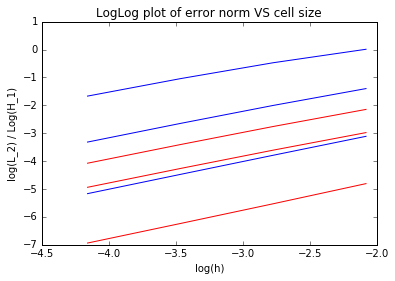

,alpha,C_alpha,beta,C_beta
0.1,0.928208,0.81701,0.808787,5.62651
0.3,0.943433,0.366261,0.922828,1.70776
1.0,1.024,0.0683329,0.988169,0.348477


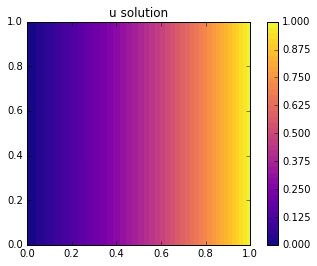

In [31]:
prob_2(1, galerkin=True)

## Problem 2 - discussion

**Analytical Solution**  

Our boundary value problem reads:
$$ -\mu\Delta + u_x = 0 \; in \; \Omega$$

with Dirichlet BC's;

$$u = 0 \; for \; x = 0$$

$$u = 1 \; for \; x = 1$$

and Neumann BC's:
$$\frac{\partial{u}}{\partial{n}} = 0 \; for \; y=0 \; and \; y=1$$


We can solve this analytically by the method of seperation of variables, we let $u(x,y) = g(x)h(y)$ and plugging into our original equation and dividing by $\mu$ gives us the two equations

$$g''(x) - \frac{1}{\mu} - C_0 g(x) = 0 \,,$$
$$h''(y) + C_0 h(y) = 0 \,,$$


Solving for h and using the above Neumann b.c, we obtain:
$$h(y) = C_1 \cos(n \pi y), \; for \: n=0,1,2, ..$$

Choosing $n = 0$ we have $C_0 = 0$, and our expression for $h(y)$ becomes

$$h(y) = C_1$$


with $n = 0$, our expression for $g(x)$ can be expressed as

$$g''(x) - \frac{1}{\mu} g'(x) = 0$$

which gives the expression for $g(x)$

$$g(x) = C_2 e^{\frac{1}{\mu} x} + C_3$$

using the dirichlet conditions, we can solve for $C_2$ and $C_3$ we obtain the analytical expression for $u$ as 

$$u(x,y) = g(x)h(y) = \frac{e^{\frac{1}{\mu} x} - 1}{e^{\frac{1}{\mu}} - 1}$$


**Numerical error**  

Problem 2 includes a convective $u_x$ term, and we can therefore reasonably expect a upwinding scheme to stablize the solution of our system. Both the $L_1$ and $H^1$ tend to zero linearly with the mesh size for both Lagrange elements of degree and 2. However, the $H^1$ norm tends to zero faster than the $L_1$ norm for lagrange elements of order 1. We can also see from the $C_\alpha$ and $C_\beta$ terms for upwinding leads to more accurate results for small $\mu$ where the $u_x$ term dominates and low values of $N$